# Neural networks for algorithmic trading. 
# Part 1. Simple time series forecasting



Ciao, people!

This is first part of my experiments on application of deep learning to finance, in particular to algorithmic trading.
I want to implement trading system from scratch based only on deep learning approaches, so for any problem we have here (price prediction, trading strategy, risk management) we gonna use different variations of artificial neural networks (ANNs) and check how well they can handle this.

In this, first part, I want to show how MLPs, CNNs and RNNs can be used for financial time series prediction. In this part we are not going to use any feature engineering. Let's just consider historical dataset of S&P500 index price movements. We have information from 2050 to 2016 about open, close, high, low prices for every day in the year and volume of trades. First, we will try just to predict close price in the end of the next day, second, we will try to predict return (close price - open price).

We will consider our problem as 1) regression problem (trying to forecast exactly close price or return next day) 2) binary classification problem (price will go up [1; 0] or down [0; 1]). 

In [168]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D

%matplotlib inline  

In [169]:
def load_snp_returns():
    f = open('table.csv', 'rb').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.decode().split(',')[1])
            close_price = float(line.decode().split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.decode().split(',')[0])
        except:
            continue

    return raw_data[::-1], raw_dates[::-1]


def load_snp_close():
    f = open('table.csv', 'rb').readlines()[1:]
    #ff = base64.b64encode(f.read())
    raw_data = []
    raw_dates = []
    #print(f)
    for line in f:
        try:
            #print(type(line))
            #print(dir(line))
            #print ("line = {0}".format(line.decode()))
            close_price = float(line.decode().split(',')[4])
            #print ("close price = {0}".format(str(close_price)))
            raw_data.append(close_price)
            raw_dates.append(line.decode().split(',')[0])
        except Exception as e:
            print (e)
            continue
    return raw_data, raw_dates


def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y


def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b


def create_Xt_Yt(X, y, percentage=0.8):
    #percentage = 1.0
    X_train = X[0:len(X) * percentage]
    Y_train = y[0:len(y) * percentage]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[len(X) * percentage:]
    Y_test = y[len(X) * percentage:]

    return X_train, X_test, Y_train, Y_test

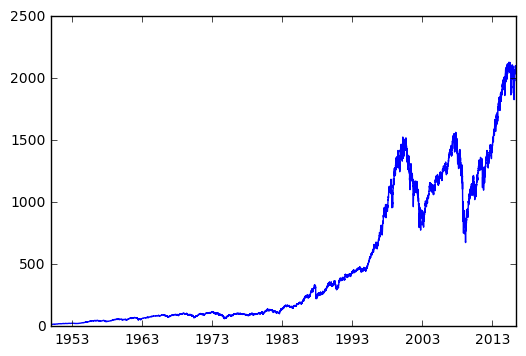

In [170]:
timeseries, dates = load_snp_close()
#print(dates)
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

plt.plot(dates, timeseries)

In [171]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:88: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:89: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [172]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          epochs=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score)

Train on 13513 samples, validate on 1502 samples
Epoch 1/5
13513/13513 [==============================] - 1s - loss: 0.3054 - val_loss: 0.0648
Epoch 2/5
13513/13513 [==============================] - 0s - loss: 0.0725 - val_loss: 0.0117
Epoch 3/5
13513/13513 [==============================] - 0s - loss: 0.0400 - val_loss: 0.0094
Epoch 4/5
13513/13513 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0050
Epoch 5/5
 128/1669 [=>............................] - ETA: 0s0.00438194918469


937.06


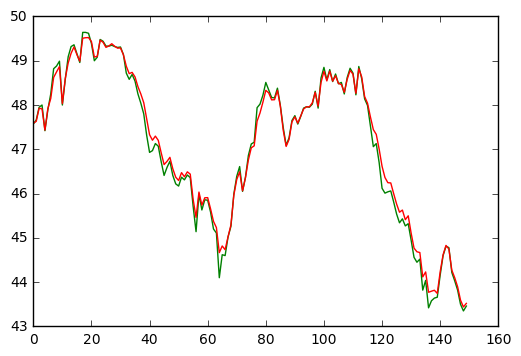

In [174]:
params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    #print("pred : {0}".format(pred))
    #print("par  {0}".format(par))
    a = pred*par[1]
    #print("a = {0}".format(a))
    a += par[0]
    #print("a1 = {0}".format(a))
    new_predicted.append(a)
    

mse = mean_squared_error(predicted, new_predicted)
print (mse)

try:
    fig = plt.figure()
    #plt.plot(Y_test[:150], color='black') # BLUE - trained RESULT
    #plt.plot(predicted[:150], color='blue') # RED - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    plt.plot(new_predicted[:150], color='red') # ORANGE - restored PREDICTION
    plt.show()
except Exception as e:
    print (str(e))

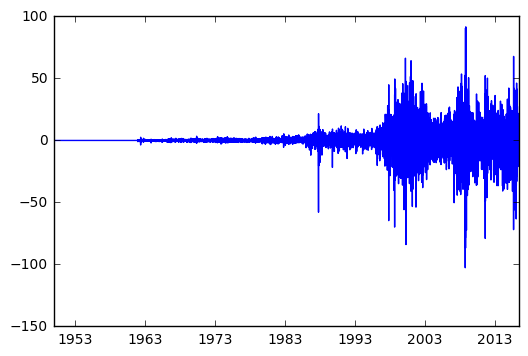

In [90]:
timeseries, dates = load_snp_returns()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [106]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)

print ("X = {0} Y = {1}".format(len(X), len(Y)))

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

X = 16684 Y = 16684


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:88: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [114]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
print(X_train.shape)
HIDDEN_RNN = 1
#model.add(LSTM(64, input_dim=64, input_length=10, return_sequences=True))
model = Sequential()

model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=True))
model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=False))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])

(15015, 20, 1)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=1)`
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 1), units=1)`


In [115]:
model.fit(X_train, 
          Y_train, 
          nb_epoch=5, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)


score = model.evaluate(X_test, Y_test, batch_size=128)
print (score)

/opt/conda/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 13513 samples, validate on 1502 samples
Epoch 1/5
13513/13513 [==============================] - 2s - loss: 0.2150 - acc: 0.8975 - val_loss: 0.1716 - val_acc: 1.0000
Epoch 2/5
13513/13513 [==============================] - 2s - loss: 0.1250 - acc: 1.0000 - val_loss: 0.0749 - val_acc: 1.0000
Epoch 3/5
13513/13513 [==============================] - 2s - loss: 0.0351 - acc: 1.0000 - val_loss: 0.0113 - val_acc: 1.0000
Epoch 4/5
13513/13513 [==============================] - 2s - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 5/5
1536/1669 [==========================>...] - ETA: 0s[0.0029855150342436251, 1.0]


In [294]:
timeseries, dates = load_snp_returns()
X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Y_train, Y_test = np.array([y.argmax() for y in Y_train]), np.array([y.argmax() for y in Y_test])


from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics, svm
from sklearn import linear_model

print 'Training...'

#classifier = RandomForestClassifier(n_estimators = 100,
#                               n_jobs=4,
#                               verbose=1)

#classifier = linear_model.LogisticRegression(C=1e-5)

classifier = svm.SVC()
classifier.fit(X_train, Y_train)

print 'Prediction...'
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(Y_test, predicted)))

C:\Users\Alex\Anaconda2\lib\site-packages\ipykernel\__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Alex\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Alex\Anaconda2\lib\site-packages\ipykernel\__main__.py:80: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Alex\Anaconda2\lib\site-packages\ipykernel\__main__.py:81: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Training...
Prediction...
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.54      0.65      0.59       913
          1       0.43      0.32      0.37       756

avg / total       0.49      0.50      0.49      1669


